# Latent optimization with e4e, styleGAN and CLIP

## 1. Load pretrained pSp

In [2]:
from argparse import Namespace
import time
import sys
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.amp import autocast
from tqdm import tqdm
import clip

from utils.common import tensor2im
from utils.alignment import run_alignment
from models.psp import pSp  # we use the pSp framework to load the e4e encoder.
from criteria.clip_loss import CLIPLoss
from criteria.id_loss import IDLoss

%load_ext autoreload
%autoreload 2
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'
IMAGE_PATH = "input_images/input_img.jpg"
RESIZE_DIMS = (256, 256)

In [3]:
# Define the arguments for the e4e encoder

pretrained_pSp_path = 'pretrained_models/e4e_ffhq_encode.pt'

e4e_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]
)

In [4]:
# Load the pSp model

ckpt = torch.load(pretrained_pSp_path, map_location='cpu')
opts = ckpt['opts']
opts['checkpoint_path'] = pretrained_pSp_path
opts['ir_se50_weights'] = 'pretrained_models/model_ir_se50.pth'
opts= Namespace(**opts)
latent_avg = ckpt["latent_avg"]

psp_model = pSp(opts)
psp_model.eval()
psp_model.cuda()

print('Model successfully loaded!')

Loading e4e over the pSp framework from checkpoint: pretrained_models/e4e_ffhq_encode.pt
Model successfully loaded!


## 2 Load an emotion model

In [5]:
from emotionmmodel.networks.DDAM import DDAMNet
emotion_model = DDAMNet(num_class=7, num_head=2, pretrained=False)
path = "checkpoints/affecnet7_epoch19_acc0.671.pth"
checkpoint = torch.load(path, map_location=device)
emotion_model.load_state_dict(checkpoint['model_state_dict'])
emotion_model.to(device)
emotion_model.eval()    
val_transform = transforms.Compose([
        transforms.Resize((112, 112)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])]) 
emotion_loss = torch.nn.CrossEntropyLoss()


In [6]:
## How to use the model

test_path = "input_images/image.png"
test_image = Image.open(test_path).convert("RGB")
image_transformed = val_transform(test_image)

# Add a batch dimension and move the image to the same device as the model
image_transformed = image_transformed.unsqueeze(0).to(device)

# Get the model prediction
predict,feat,heads  = emotion_model(image_transformed)
test_distribution = torch.tensor([[0.1, 0.2, 0.1, 0.3, 0.1, 0.1, 0.1]], device=device)
import torch.nn.functional as F

# Compute probabilities with softmax (along the class dimension)
probs = F.softmax(predict, dim=1)

# Get the index with the highest probability
predicted_index = torch.argmax(probs, dim=1).item()

# Mapping from index to emotion
class7_names = ['Neutral', 'Happy', 'Sad', 'Surprise', 'Fear', 'Disgust', 'Angry']

# Print the exact emotion
print("Exact emotion:", class7_names[predicted_index])

print(probs)


Exact emotion: Angry
tensor([[0.0187, 0.0012, 0.0170, 0.0080, 0.0370, 0.1096, 0.8085]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)


## 3. Load a text to emotion model

In [8]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("michellejieli/emotion_text_classifier")
text_model = AutoModelForSequenceClassification.from_pretrained("michellejieli/emotion_text_classifier")

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
text_model.to(device)
text_model.eval()  # Set to evaluation mode

def predict_emotion(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    
    # Move tensors to device
    inputs = {key: value.to(device) for key, value in inputs.items()}
    
    # Get model predictions
    with torch.no_grad():
        outputs = text_model(**inputs)
    
    # Get probabilities using softmax
    probabilities = F.softmax(outputs.logits, dim=-1)
    
    # Get predicted class
    predicted_class = torch.argmax(probabilities, dim=-1).item()

    emotion_labels = ["anger", "disgust", "fear", "joy", "neutrality", "sadness", "surprise"]
    
    return emotion_labels[predicted_class], probabilities.squeeze().tolist()

text = "I am surprised"
emotion, probs = predict_emotion(text)

print(f"Predicted Emotion: {emotion}")
print(f"Probabilities: {probs}")


/users/eleves-b/2022/hamza.azzouzi/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Predicted Emotion: surprise
Probabilities: [0.0016623727278783917, 0.001146192429587245, 0.001822841470129788, 0.001165489200502634, 0.04635213315486908, 0.000502795388456434, 0.9473481774330139]


In [9]:
import os
import glob
import matplotlib.pyplot as plt
import torch
from PIL import Image
import torchvision.transforms as transforms
%matplotlib inline

# Define your mappings:
# Model's label order
class7_names = ['Neutral', 'Happy', 'Sad', 'Surprise', 'Fear', 'Disgust', 'Angry']

# Mapping from model predicted index to fernet index:
# Model index: 0     1      2      3         4      5         6  
# Model label:  Neutral, Happy, Sad, Surprise, Fear, Disgust, Angry  
# Fernet index: 6 (Neutral), 3 (Happy), 4 (Sad), 5 (Surprise), 2 (Fear), 1 (Disgust), 0 (Angry)
model_idx_to_fernet_idx = {
    0: 6,
    1: 3,
    2: 4,
    3: 5,
    4: 2,
    5: 1,
    6: 0
}

# Mapping from fernet index to emotion string.
fernet_idx_to_emotion = {
    0: "Angry",
    1: "Disgust",
    2: "Fear",
    3: "Happy",
    4: "Sad",
    5: "Surprise",
    6: "Neutral"
}

# Set your device and assume your model is already loaded, moved to device, and in eval mode.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# For example:
# model = DDAMNet(num_class=7, num_head=2, pretrained=False)
# ... load checkpoint, model.to(device), model.eval(), etc.

# Folder that contains your 15-20 images
test_folder = 'Test_Hamza_images'  # <-- update this to your folder path
image_paths = glob.glob(os.path.join(test_folder, "*"))

# Define the transform consistent with your model preprocessing.
transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# List to hold (PIL Image, predicted emotion)
predictions = []

# Loop over each image in the folder.
for img_path in image_paths:
    try:
        # Open image and ensure it's in RGB mode.
        img = Image.open(img_path).convert("RGB")
    except Exception as e:
        print(f"Error opening {img_path}: {e}")
        continue
    
    # Apply the transform and add a batch dimension.
    input_tensor = transform(img).unsqueeze(0).to(device)
    
    # Get prediction from the model.
    with torch.no_grad():
        # Adjust the unpacking if your model returns additional outputs.
        outputs, _, _ = model(input_tensor)
        _, predicted = torch.max(outputs.data, 1)
    
    # Map the model's prediction to the corresponding fernet index and emotion string.
    mapped_idx = model_idx_to_fernet_idx[predicted.item()]
    emotion = fernet_idx_to_emotion[mapped_idx]
    
    predictions.append((img, emotion))

# Now, display the images with their predicted labels.
num_images = len(predictions)
cols = 4  # Adjust number of columns as desired.
rows = (num_images + cols - 1) // cols  # Compute number of rows needed.
print(predictions)
plt.figure(figsize=(15, 15))
for i, (img, emotion) in enumerate(predictions):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(emotion)
    plt.axis('off')

plt.tight_layout()
plt.show()


NameError: name 'model' is not defined

## 2. Latent optimization with CLIP loss

Given a source latent code $w_s \in W^+$, and a directive in natural language, or a text prompt $t$, we solve the following optimization problem:

$$ argmin_{w \in \mathbb W^+} \, D_{CLIP}(G(w), t) + \lambda_{L2} \left\| w - w_s \right\|_2 + \lambda_{ID} \mathcal L_{ID}(w) $$

where $G$ is a pretrained StyleGAN generator and $D_{CLIP}$ is the cosine distance between the CLIP embeddings of its two arguments. Similarity to the input image is controlled by the $L^2$ distance in latent space, and by the identity loss:

$$ \mathcal{L}_{ID}(w) = 1 - \langle R(G(w_s)), R(G(w)) \rangle $$

where $R$ is a pretrained ArcFace network for face recognition, and $ \langle \cdot , \cdot \rangle $ computes the cosine similarity between its arguments.



Aligned image has shape: (256, 256)


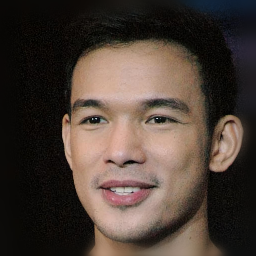

In [11]:
# Define the image

image_path = IMAGE_PATH
original_image = Image.open(image_path).convert("RGB")
image = run_alignment(image_path).resize(RESIZE_DIMS)

# show the input image
input_image = e4e_transform(image)
image


In [12]:
# compute w_start

with torch.no_grad():
    w_s = psp_model.encoder(input_image.unsqueeze(0).to(device))
if psp_model.opts.start_from_latent_avg:
                if w_s.ndim == 2:
                    w_s = w_s + psp_model.latent_avg.repeat(w_s.shape[0], 1, 1)[:, 0, :]
                else:
                    w_s = w_s + psp_model.latent_avg.repeat(w_s.shape[0], 1, 1)
print(w_s.shape)

torch.Size([1, 18, 512])


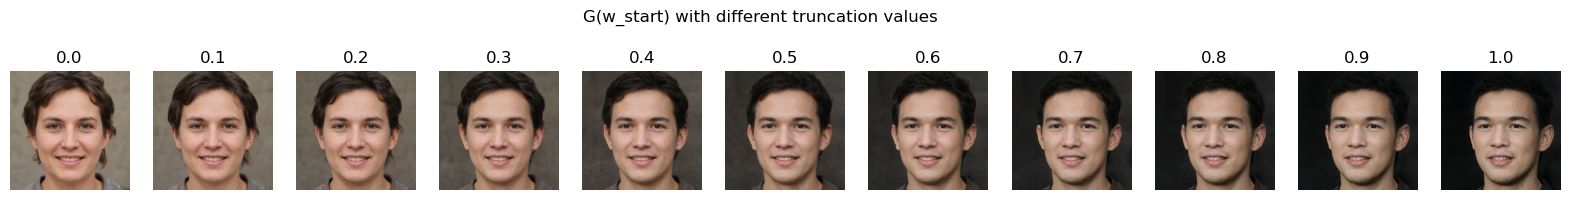

In [13]:
# Visualize G(w_s) with different truncation values

plt.figure(figsize=(20, 2.5))

for i, truncation in enumerate(np.linspace(0, 1, 11)):
    with torch.no_grad():
        with torch.amp.autocast("cuda"):
            generated_image, _ = psp_model.decoder([w_s], input_is_latent=True,
                                                    truncation=truncation,
                                                    truncation_latent=psp_model.latent_avg.to(device))
            show_img = tensor2im(generated_image.squeeze(0).cpu())
            plt.subplot(1, 11, i + 1)
            plt.title(f'{truncation:.1f}')
            # plt.imshow(generated_image.squeeze(0).cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5)
            plt.imshow(show_img)
            plt.axis('off')
            
plt.suptitle('G(w_start) with different truncation values')
plt.show()

In [16]:
# Load pretrained models for losses

clip_loss = CLIPLoss(opts)
id_loss = IDLoss(opts)

Loading ResNet ArcFace


In [61]:
def scale_img_for_emotion_model(x):
    # x is shape (B, 3, H, W) in [-1,1]
    x = (x + 1) / 2  # Now in [0,1]
    return x

def normalize_for_emotion_model(x):
    # Normalizing using ImageNet-like mean/std
    mean = torch.tensor([0.485, 0.456, 0.406], device=x.device).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=x.device).view(1, 3, 1, 1)
    return (x - mean) / std


In [138]:
optimization_steps = 40
lambda_L2 = 0.012
lambda_ID = 0
lambda_emotion = 0.03
lr = 0.1 ### TODO : améliorer ça en ajoutant un scheduler cf StyleCLIP/run_optimization.py
truncation = 0.9

prompt = "A blond man with blue eyes"

save_img_every_other = optimization_steps // 10
G = psp_model.decoder # StyleGan2 generator

In [141]:
from torchvision.transforms.functional import to_pil_image

w_n = w_s.clone().detach().requires_grad_(True).to(device) # initialization with e4e output
# w_n = torch.randn(w_s.shape).to(device).requires_grad_(True) # random initialization in latent space
# w_n = psp_model.latent_avg.clone().detach().unsqueeze(0).requires_grad_(True).to(device) # initialization with latent_avg
optimizer = torch.optim.Adam([w_n], lr=lr)

text_inputs = torch.cat([clip.tokenize(prompt)]).cuda()
# class7_names = ['Neutral', 'Happy', 'Sad', 'Surprise', 'Fear', 'Disgust', 'Angry']
goal_distribution = torch.tensor([[0., 1., 0., 0., 0., 0., 0.]], device=device)

with torch.no_grad():
    img_orig, _ = G([w_n], input_is_latent=True)

pbar = tqdm(range(optimization_steps))

imgs = []
for i in pbar:
    with autocast("cuda"):
        optimizer.zero_grad()

        img_gen, _ = G([w_n], input_is_latent=True, randomize_noise=False)

        # --- Clip loss, identity loss, L2 loss as before ---
        c_loss = clip_loss(img_gen, text_inputs)
        i_loss = id_loss(img_gen, img_orig)[0]
        l2_loss = ((w_s - w_n) ** 2).sum()

        # --- Instead of going to PIL, do in-graph transforms ---
        # 1) Scale to [0,1] if needed
        img_for_emotion = scale_img_for_emotion_model(img_gen)
        # 2) Resize to (112, 112)
        img_for_emotion = F.interpolate(img_for_emotion, size=(112, 112), mode='bilinear', align_corners=False)
        # 3) Normalize
        img_for_emotion = normalize_for_emotion_model(img_for_emotion)
        # Now feed directly to emotion model (gradients will flow back!)
        prediction, feat, heads = emotion_model(img_for_emotion)
        e_loss = emotion_loss(prediction, goal_distribution)

        # --- Combine losses ---
        loss = c_loss + lambda_L2 * l2_loss + lambda_ID * i_loss + lambda_emotion * e_loss
        pbar.set_description(f"Loss: {loss.item():.4f}")

        loss.backward()
        optimizer.step()

        if i % save_img_every_other == 0 or i == optimization_steps - 1:
            imgs.append(tensor2im(img_gen.squeeze(0).cpu()))


print(prediction)
   


Loss: 0.7920: 100%|██████████| 40/40 [00:09<00:00,  4.01it/s]

tensor([[-1.3770,  7.0000, -3.0469,  1.1914, -2.0723, -0.3831, -3.3867]],
       device='cuda:0', dtype=torch.float16, grad_fn=<AddmmBackward0>)


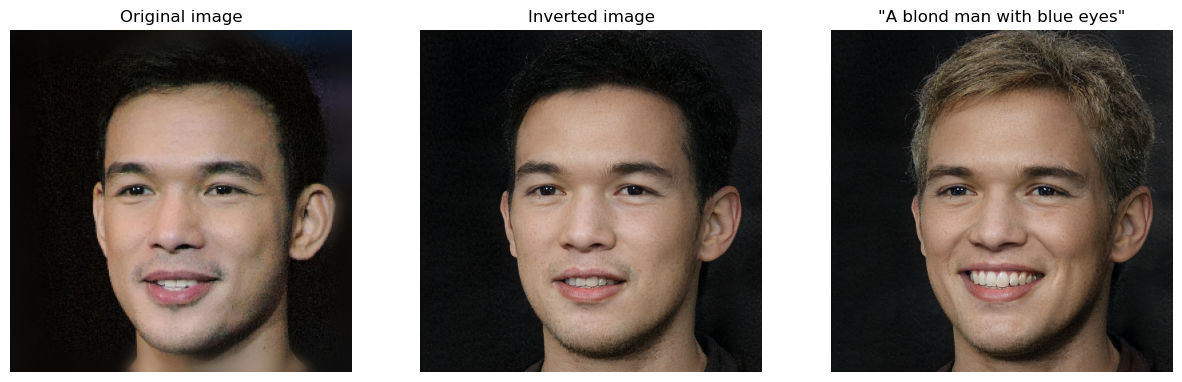

In [142]:
# Plot final image next to original image

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('Original image')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(imgs[0])
plt.title('Inverted image')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(imgs[-1])
plt.title(f'"{prompt}"')
plt.axis('off')
plt.show()

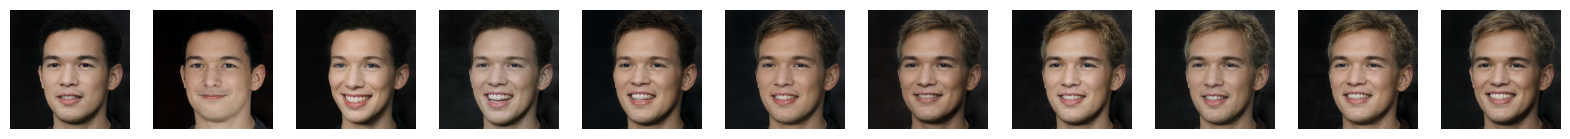

In [143]:
# Plot intermediate images

plt.figure(figsize=(20, 3))
for i in range(len(imgs)):
    plt.subplot(1, len(imgs), i + 1)
    plt.imshow(imgs[i])
    plt.axis('off')
plt.show()